# Workshop: Solving the Traveling Salesperson Problem with Quantum-Inspired Optimization (QUBO)

In this notebook, we'll walk through the process of solving a classic combinatorial optimization problem—the Traveling Salesperson Problem (TSP)—using a quantum-inspired approach.

As discussed in the presentation (slides 12-18), the core idea is to:
1.  **Describe the problem** mathematically.
2.  **Formulate it as a QUBO** (Quadratic Unconstrained Binary Optimization) model.
3.  **Use a solver** to find the minimum energy state of the model, which corresponds to the optimal solution.
4.  **Interpret the results** to find our answer.

We will use classical Python libraries (`pyqubo` and `neal`) that are designed to build and solve these models efficiently.

## Step 1: Setup and Dependencies

First, we need to import the necessary libraries.
- `numpy` is for numerical operations, especially for our distance matrix.
- `matplotlib.pyplot` is for visualizing our cities and the final solution path.
- `pyqubo` is the core library we'll use to create our QUBO model in an intuitive, symbolic way.
- `neal` provides the Simulated Annealing sampler, a powerful classical algorithm that is excellent for solving QUBO problems.

In [1]:
# Core scientific computing and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

# pyqubo for building the QUBO model
from pyqubo import Array, Constraint, Placeholder

# neal for the simulated annealing solver
import neal

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Problem Definition

The **Traveling Salesperson Problem (TSP)** asks: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?"

This is a famously difficult (NP-hard) problem. For our workshop, we will solve it for 5 European capitals.

In [2]:
# Define our list of cities
cities = ['Berlin', 'Paris', 'Rome', 'Madrid', 'Warsaw']
n_cities = len(cities)

# Create a distance matrix (symmetric) with approximate road distances in km
dist_matrix = np.array([
    # BER   PAR    ROM    MAD    WAR
    [0,    1054,  1501,  2309,  574],   # Berlin
    [1054, 0,     1420,  1276,  1619],  # Paris
    [1501, 1420,  0,     1970,  1837],  # Rome
    [2309, 1276,  1970,  0,     3281],  # Madrid
    [574,  1619,  1837,  3281,  0]     # Warsaw
])

# We also define coordinates for plotting to make the map look nice
coords = {
    'Berlin': [0.6, 0.9],
    'Paris': [0.1, 0.7],
    'Rome': [0.4, 0.2],
    'Madrid': [-0.2, 0.1],
    'Warsaw': [1.0, 0.8]
}
city_coords = np.array([coords[city] for city in cities])

print(f"Problem defined for {n_cities} cities.")

Problem defined for 5 cities.


### Visualizing the Cities

Let's create a helper function to plot the cities on a 2D map. This will help us visualize the problem and later, the solution.

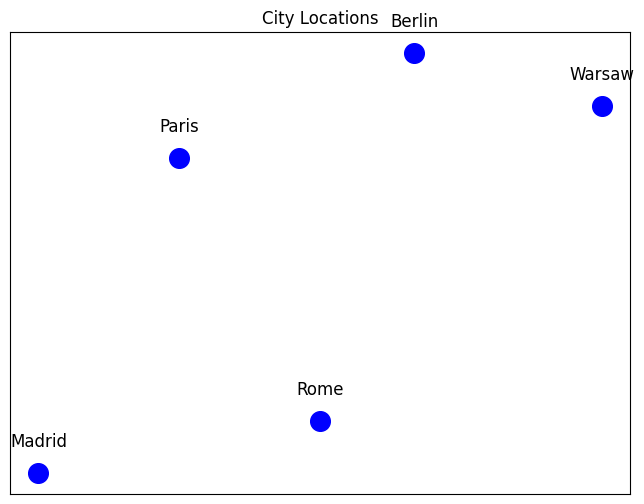

In [3]:
def plot_tour(coordinates, city_names, path=None):
    """Helper function to plot the cities and the tour."""
    plt.figure(figsize=(8, 6))
    
    # Plot cities as blue dots
    plt.scatter(coordinates[:, 0], coordinates[:, 1], s=200, c='blue', zorder=3)
    
    # Label cities
    for i, city in enumerate(city_names):
        plt.text(coordinates[i, 0], coordinates[i, 1] + 0.05, city, ha='center', fontsize=12)
    
    # Plot the tour path if a solution is provided
    if path:
        # Close the loop by adding the start city to the end
        path_full = path + [path[0]]
        for i in range(len(path_full) - 1):
            start_node = path_full[i]
            end_node = path_full[i+1]
            plt.plot([coordinates[start_node, 0], coordinates[end_node, 0]],
                     [coordinates[start_node, 1], coordinates[end_node, 1]], 'r-')
        plt.title("TSP Solution Path")
    else:
        plt.title("City Locations")
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Plot the initial problem
plot_tour(city_coords, cities)

## Step 3: QUBO Formulation

This is the most important part. We need to translate the TSP into the language of QUBO. A QUBO model consists of an **objective function** and **constraints**.

$$H = H_{objective} + H_{constraints}$$

### 3.1 Decision Variables

First, we define our binary decision variables. As shown on slide 16, we use a variable $x_{i,j}$ which is:
- **1** if the salesperson visits city `i` at tour step `j`
- **0** otherwise

Since we have 5 cities and 5 steps in the tour (0, 1, 2, 3, 4), we will need $5 \times 5 = 25$ binary variables. `pyqubo` makes this easy to create.

In [4]:
# Create a 2D array of binary variables x_i,j
x = Array.create('x', (n_cities, n_cities), 'BINARY')

### 3.2 The Objective Function

Our goal is to **minimize the total distance** of the tour. The distance of the tour is the sum of distances between consecutive cities in the path.

Mathematically, this is expressed as:
$$ H_{objective} = \sum_{k=0}^{N-1} \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} c_{ij} \cdot x_{i,k} \cdot x_{j, k+1} $$

This formula adds the distance $c_{ij}$ (from city `i` to city `j`) to the total cost *if* we visit city `i` at step `k` AND we visit city `j` at step `k+1`.

In [ ]:
# Objective function: Sum of distances for the selected path
objective_func = 0
for k in range(n_cities):
    for i in range(n_cities):
        for j in range(n_cities):
            # The modulo operator % n_cities handles the return trip from the last city to the first
            objective_func += dist_matrix[i, j] * x[i, k] * x[j, (k + 1) % n_cities]

print("Objective function created.")

### 3.3 The Constraints

The objective function alone is not enough. We need to enforce the rules of the TSP. We do this by adding **penalty terms** to our Hamiltonian. If a rule is broken, the penalty term will add a large value to the total energy, so the solver will learn to avoid breaking the rules.

As on slide 17, we have two constraints:
1.  **Each city must be visited exactly once.** For each city `i`, the sum of $x_{i,j}$ over all steps `j` must be equal to 1.
    - Penalty: $ P \cdot (\sum_{k=0}^{N-1} x_{i,j} - 1)^2 $
2.  **At each step, exactly one city must be visited.** For each step `j`, the sum of $x_{i,j}$ over all cities `i` must be equal to 1.
    - Penalty: $ P \cdot (\sum_{i=0}^{N-1} x_{i,j} - 1)^2 $

The term $P$ is a large number called the penalty weight. It must be chosen carefully: large enough to enforce the constraints, but not so large that it completely dominates the objective function (see slide 19).

In [ ]:
# We use a Placeholder for the penalty weight. This lets us set the value at compile time.
P = Placeholder("penalty_weight")

# Constraint 1: Each city must be visited exactly once.
constraint_city = 0
for i in range(n_cities):
    # The sum of x_i,k over all steps k should be 1
    constraint_city += Constraint((sum(x[i, k] for k in range(n_cities)) - 1)**2, label=f"city_visited_{i}")

# Constraint 2: At each step, exactly one city is visited.
constraint_step = 0
for k in range(n_cities):
    # The sum of x_i,k over all cities i should be 1
    constraint_step += Constraint((sum(x[i, k] for i in range(n_cities)) - 1)**2, label=f"city_visited_at_step_{k}")
    
# Construct the final Hamiltonian
H = objective_func + P * (constraint_city + constraint_step)

print("Final Hamiltonian constructed.")

## Step 4: Compile and Solve the QUBO

With our Hamiltonian defined, we can now:
1.  **Compile** the model. This converts our symbolic expression into a numerical QUBO matrix.
2.  **Define the penalty value**. A good rule of thumb is to set it to be larger than the maximum possible tour distance.
3.  **Send it to the solver**. The `neal` sampler will attempt to find the assignment of 0s and 1s to our `x` variables that results in the lowest value for `H`.

In [ ]:
# 1. Compile the model
model = H.compile()

# 2. Define the penalty value. The longest possible path is roughly the sum of the 4 longest edges.
# A value like 4000 should be safely larger than any possible tour distance.
feed_dict = {'penalty_weight': 4000.0}

# 3. Convert the compiled model to a QUBO dictionary
qubo, offset = model.to_qubo(feed_dict=feed_dict)

# 4. Solve the QUBO with the simulated annealer
sampler = neal.SimulatedAnnealingSampler()
# num_reads is the number of times the annealer will run. More reads increase the chance of finding the optimal solution.
sampleset = sampler.sample_qubo(qubo, num_reads=100)

# 5. Decode the best solution found
decoded_sample = model.decode_sample(sampleset.first.sample, vartype='BINARY', feed_dict=feed_dict)

print("Solver has finished.")

## Step 5: Interpret and Visualize the Solution

The solver returns a sample with the lowest energy it found. We need to parse this sample to reconstruct the tour path and check if it's a valid solution (i.e., no constraints are broken).

In [ ]:
# Check for broken constraints in the best solution
num_broken = len(decoded_sample.constraints(only_broken=True))

if num_broken > 0:
    print(f"Found a solution with {num_broken} broken constraints.")
    print("Try increasing the penalty_weight or running more reads.")
    print(decoded_sample.constraints(only_broken=True))
else:
    print("Found a valid solution with 0 broken constraints!")
    
    # Reconstruct the path from the solution dictionary
    path = [-1] * n_cities
    for i in range(n_cities):
        for k in range(n_cities):
            if decoded_sample.array('x', (i, k)) == 1:
                path[k] = i
    
    # Print the results
    path_str = " -> ".join([cities[i] for i in path])
    print(f"\nOptimal path found: {path_str} -> {cities[path[0]]}")
    
    # Calculate total distance
    total_dist = sum(dist_matrix[path[k], path[(k + 1) % n_cities]] for k in range(n_cities))
    print(f"Total distance: {total_dist:.2f} km")
    
    # Plot the final tour
    plot_tour(city_coords, cities, path)